# Distance/Reconstruction기반 Novelty Detection

![title](http://cfile221.uf.daum.net/image/99E88E335A1A80172E7666)

# 2. K-Means clustering-based novelty detection

![title](http://cfile236.uf.daum.net/image/9916F9335A1A801420F20B)

## 1) K-Means Algorithm

![title](http://cfile213.uf.daum.net/image/996C0D335A1A80151872BF)

## 2) K-Means Python Code

### Data준비

In [36]:
%matplotlib inline
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

#파일로 데이터 입력(Column Name없이), 파일명 : ex_kmc.csv
def loadDataset(filename, split, trainingSet=[] , testSet=[]):
    with open(filename, 'r') as csvfile:
        lines = csv.reader(csvfile)
        dataset = list(lines)
        for x in range(len(dataset)):
            for y in range(2):
                dataset[x][y] = float(dataset[x][y])
            if random.random() < split:
                trainingSet.append(dataset[x])
            else:
                testSet.append(dataset[x])                

Train set:  1509
Test set: 0
Train set:  [[1.996251169, 0.931077233, '1'], [-1.298157109, -2.322357985, '1'], [1.844962177, -1.774005487, '1'], [-0.266268692, -1.735327618, '1'], [-2.265353559, -0.367262574, '1'], [-0.089113845, -1.810973134, '1'], [-1.603322368, -1.983500956, '1'], [-2.054007548, -1.846174646, '1'], [1.726899216, 1.417497251, '1'], [1.786822248, 2.201596215, '1']]


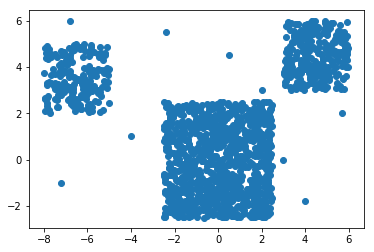

In [43]:
def main():
    
    # prepare data
    trainingSet=[]
    testSet=[]
    split = 1
    random.seed(100)
    loadDataset('C:/Users/myunghoon/.spyder-py3/ex_kmc.csv', split, trainingSet, testSet)
    trainX=np.array(trainingSet)
    
    #print('Train set: ' ,repr(len(trainingSet)))
    #print('Test set: ' + repr(len(testSet)))
    #print('Train set: ' ,trainingSet[0:10])
    #a=trainX[:,:-1].astype(np.float)
    #plt.scatter(a[:,0], a[:,1]);

main()

### ① 첫번째 Centroid선정

In [46]:
def kmeans(X,k,maxIt):
    numPoints,numDim=X.shape

    dataSet=np.zeros((numPoints,numDim+1))
    dataSet[:,:-1]=X
    centroids=dataSet[np.random.randint(numPoints,size=k),:]
    centroids[:,-1]=range(1,k+1)
    print("centroids:",centroids)

![title](http://cfile218.uf.daum.net/image/99AD71335A1A801512B4D8)

In [49]:
def main():
    # prepare data
    trainingSet=[]
    testSet=[]
    split = 1
    random.seed(100)
    loadDataset('C:/Users/myunghoon/.spyder-py3/ex_kmc.csv', split, trainingSet, testSet)
    trainX=np.array(trainingSet)

    # k=군집개수, max_iter=반복 회수 제한(Hyper parameter)   
    k=3
    max_iter=100
    final_result=kmeans(trainX[:,:-1],k,max_iter)
    
main()

centroids: [[-0.43298092  2.26309732  1.        ]
 [-0.35933221 -1.52023601  2.        ]
 [ 4.29683051  5.96444208  3.        ]]


### ② 첫번째 Cluster할당

In [52]:
def kmeans(X,k,maxIt):
    numPoints,numDim=X.shape

    dataSet=np.zeros((numPoints,numDim+1))
    dataSet[:,:-1]=X
    centroids=dataSet[np.random.randint(numPoints,size=k),:]
    centroids[:,-1]=range(1,k+1)

    iterations=0;
    oldCentroids=None
    
    while not shouldStop(oldCentroids, centroids, iterations, maxIt):
        oldCentroids=np.copy(centroids)
        iterations+=1
        updateLabels(dataSet, centroids)
        centroids=getCentroids(dataSet, k)
    return dataSet, centroids

def shouldStop(oldCentroids,centroids,iterations,maxIt):
    if iterations>maxIt:
        return True
    return np.array_equal(oldCentroids, centroids)

1) While not문은 그 구문이 False이면 계속 Looping을 돈다(While과 반대). 즉 ShouldStop에서 True를 Return하면 While문 종료.

2) np.array_equal(a,b) → a,b가 같으면 True, 다르면 False

In [53]:
def updateLabels(dataSet,centroids):
    numPoints,numDim=dataSet.shape
    for i in range(numPoints):
        dataSet[i,-1]=getLabelFromClosestCentroid(dataSet[i,:-1], centroids)

def getLabelFromClosestCentroid(dataSetRow,centroids):
    label=centroids[0,-1]
    minDist=np.linalg.norm(dataSetRow-centroids[0,:-1])
    for i in range(1,centroids.shape[0]):
        dist=np.linalg.norm(dataSetRow-centroids[i,:-1])
        if dist<minDist:
            minDist=dist
            label=centroids[i,-1]
            #print("label:"+str(label))
    return label

![title](http://cfile212.uf.daum.net/image/99B172335A1A801526B9BB)

### ③ Centroid의 새 좌표 구하기

In [54]:
def getCentroids(dataSet,k):       
    result=np.zeros((k,dataSet.shape[1]))
    #print("result:",result)
    for i in range(1,k+1):
        oneCluster=dataSet[dataSet[:,-1]==i,:-1]
        #print("cluster:",oneCluster)
        result[i-1,:-1]=np.mean(oneCluster,axis=0)
        result[i-1,-1]=i
    #print("result:",result)
    return result

![title](http://cfile229.uf.daum.net/image/990481335A1A801636C33F)

### ④ 더 이상 군집의 Centroid가 변경되지 않을 때까지 iteration

In [57]:
def shouldStop(oldCentroids,centroids,iterations,maxIt):
    if iterations>maxIt:
        return True
    return np.array_equal(oldCentroids, centroids)

### ⑤ Novelty Score (최근접 군집 Centroid와의 거리)

In [59]:
def getNoveltyScore(dataSetRow,centroids,k):
    minDist=[]    
    for i in range(k):
        Dist=np.linalg.norm(dataSetRow[:,:-1]-centroids[i,:-1],axis=1)   
        minDist.append(Dist)        
    NoveltyScore=np.min(minDist,axis=0)
    #print(NoveltyScore)
    return NoveltyScore

![title](http://cfile209.uf.daum.net/image/999865335A1A8016152D17)

### K-Means결과

final cluster: [[ 1.99625117  0.93107723  2.        ]
 [-1.29815711 -2.32235799  2.        ]
 [ 1.84496218 -1.77400549  2.        ]
 ..., 
 [ 3.          0.          2.        ]
 [ 4.         -1.8         2.        ]
 [ 5.7         2.          1.        ]]
final centroid: [[ 4.34440535  4.42479706  1.        ]
 [ 0.04940347 -0.09926152  2.        ]
 [-6.49875619  3.46631533  3.        ]]
Novelty Score: [ 2.20268334  2.59963025  2.45536116 ...,  2.95226569  4.30113058
  2.77799885]


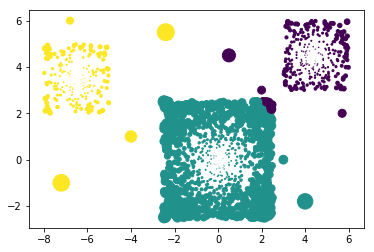

In [65]:
def main():
    # prepare data
    trainingSet=[]
    testSet=[]
    split = 1
    random.seed(100)
    loadDataset('C:/Users/myunghoon/.spyder-py3/ex_kmc.csv', split, trainingSet, testSet)
    trainX=np.array(trainingSet)
    
    #print('Train set: ' ,repr(len(trainingSet)))
    #print('Test set: ' + repr(len(testSet)))
    #print('Train set: ' ,trainingSet[0:10])
    #a=trainX[:,:-1].astype(np.float)
    #plt.scatter(a[:,0], a[:,1]);
    
    # k=군집개수, max_iter=반복 회수 제한(Hyper parameter)   
    k=3
    max_iter=100
    final_result=kmeans(trainX[:,:-1],k,max_iter)
    
    kmeans_result=final_result[0]
    centroid_result=final_result[1]
    Score=getNoveltyScore(kmeans_result,centroid_result,k)
    
    print('final cluster:',kmeans_result)
    print('final centroid:',centroid_result)
    print('Novelty Score:',Score)
    
    x=kmeans_result[:,0]
    y=kmeans_result[:,1]
    colors=kmeans_result[:,2]
    
    plt.scatter(x, y, s=(Score**3)*3, c=colors);

main()

## 3) Computing시간 비교 (매뉴얼 vs 패키지)

매뉴얼 : 0.12초, 패키지 : 0.07초

## 4) Relative Distance기반 K-Means

![title](http://cfile234.uf.daum.net/image/992A00335A1A8016094C6B)

### 문제점

![title](http://cfile218.uf.daum.net/image/9956E4335A1A80162F49C8)

### Relative Distance기반 K-Means Python Code

    #############Outlier제거##############
    
    outlier_percentage=0.98
    Distsorting=np.argsort(Score)
    outlier_point=int(Distsorting.shape[0]*outlier_percentage)    
    cutoff_index=Distsorting[0:outlier_point]
    trainX=trainX[cutoff_index]    
    
    ######################################
    


    
    
    ######## Relative Novelty Score #######
    
    def getModNoveltyScore(kmeans_result,centroid_result,maxDist,k):
    minDist=[]
    countcluster=[]    
    for i in range(k):
        Dist=np.linalg.norm(kmeans_result[:,:-1]-centroid_result[i,:-1],axis=1)
        minDist.append(Dist)
        count=np.sum(kmeans_result[:,-1]==i+1)
        countcluster.append(count)           

    NoveltyScore=np.min(minDist,axis=0)
    weight=(countcluster/np.min(countcluster))/maxDist
    scale_weight=weight/np.min(weight)
    mod_NoveltyScore = NoveltyScore*np.repeat(scale_weight,countcluster,axis=0)

    #print(np.repeat(scale_weight,countcluster,axis=0))
    #print(countcluster)
    #print(np.min(countcluster))
    #print(scale_weight)
    #print(minDist)
    #print(MaxDist)
    #print(NoveltyScore)
   
    return mod_NoveltyScore

![title](http://cfile237.uf.daum.net/image/99BA1F335A1A8017265ABF)

### Absolute Distance기반 K-Means결과

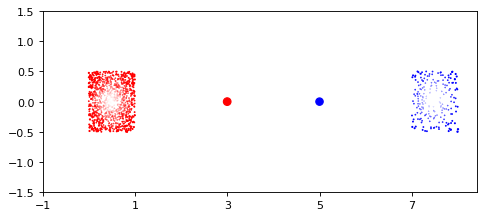

In [9]:
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

#파일로 데이터 입력(Column Name없이), 파일명 : ex_kmc.csv
def loadDataset(filename, split, trainingSet=[] , testSet=[]):
    with open(filename, 'r') as csvfile:
        lines = csv.reader(csvfile)
        dataset = list(lines)
        for x in range(len(dataset)):
            for y in range(2):
                dataset[x][y] = float(dataset[x][y])
            if random.random() < split:
                trainingSet.append(dataset[x])
            else:
                testSet.append(dataset[x])  
  
       
def kmeans(X,k,maxIt):
    numPoints,numDim=X.shape

    dataSet=np.zeros((numPoints,numDim+1))
    dataSet[:,:-1]=X
    centroids=dataSet[np.random.randint(numPoints,size=k),:]
    centroids[:,-1]=range(1,k+1)
    #print("centroids:",centroids)

    iterations=0;
    oldCentroids=None
    while not shouldStop(oldCentroids, centroids, iterations, maxIt):
        oldCentroids=np.copy(centroids)
        iterations+=1
        updateLabels(dataSet, centroids)
        centroids=getCentroids(dataSet, k)
    return dataSet, centroids

def shouldStop(oldCentroids,centroids,iterations,maxIt):
    if iterations>maxIt:
        return True
    return np.array_equal(oldCentroids, centroids)

def updateLabels(dataSet,centroids):
    numPoints,numDim=dataSet.shape
    for i in range(numPoints):
        dataSet[i,-1]=getLabelFromClosestCentroid(dataSet[i,:-1], centroids)

def getLabelFromClosestCentroid(dataSetRow,centroids):
    label=centroids[0,-1]
    minDist=np.linalg.norm(dataSetRow-centroids[0,:-1])
    for i in range(1,centroids.shape[0]):
        dist=np.linalg.norm(dataSetRow-centroids[i,:-1])
        if dist<minDist:
            minDist=dist
            label=centroids[i,-1]
            #print("label:"+str(label))
    return label

def getCentroids(dataSet,k):       
    result=np.zeros((k,dataSet.shape[1]))
    #print("result:",result)
    for i in range(1,k+1):
        oneCluster=dataSet[dataSet[:,-1]==i,:-1]
        #print("cluster:",oneCluster)
        result[i-1,:-1]=np.mean(oneCluster,axis=0)
        result[i-1,-1]=i
    #print("result:",result)
    return result

def getNoveltyScore(dataSetRow,centroids,k):
    minDist=[]    
    for i in range(k):
        Dist=np.linalg.norm(dataSetRow[:,:-1]-centroids[i,:-1],axis=1)   
        minDist.append(Dist)        
    NoveltyScore=np.min(minDist,axis=0)
    #print(minDist)
    #print(NoveltyScore)
    return NoveltyScore


def main():
    # prepare data
    trainingSet=[]
    testSet=[]
    split = 1
    random.seed(100)
    loadDataset('C:/Users/myunghoon/.spyder-py3/ex_kmc2.csv', split, trainingSet, testSet)
    trainX=np.array(trainingSet)
    
    #print('Train set: ' ,repr(len(trainingSet)))
    #print('Test set: ' + repr(len(testSet)))
    #print('Train set: ' ,trainingSet[0:10])
    #a=trainX[:,:-1].astype(np.float)
    #plt.scatter(a[:,0], a[:,1]);
    
    # k=군집개수, max_iter=반복 회수 제한(Hyper parameter)   
    k=2
    max_iter=100
    final_result=kmeans(trainX[:,:-1],k,max_iter)
    
    kmeans_result=final_result[0]
    centroid_result=final_result[1]
    Score=getNoveltyScore(kmeans_result,centroid_result,k)
    
    #print('final cluster:',kmeans_result)
    #print('final centroid:',centroid_result)
    #print('Novelty Score:',Score)
    
    x=kmeans_result[:,0]
    y=kmeans_result[:,1]
    colors=kmeans_result[:,2]
    
    plt.figure(figsize=(7, 3), dpi=80)
    plt.scatter(x, y, s=(Score**3)*3, c=colors);
    plt.xticks(np.arange(-1,8,2))
    plt.yticks(np.arange(-1.5,1.6,0.5))

main()

### Relative Distance기반 K-Means결과

final centroid: [[ 0.48733998  0.00989431  1.        ]
 [ 7.46097362  0.03209544  2.        ]]
maxDist: [2.5126795004093165, 2.4611828995070066]
Novelty Score: [ 0.27186787  0.36520021  0.47976108 ...,  0.21707354  0.15544183
  2.4611829 ]
final centroid_second: [[ 7.46139575  0.04082411  1.        ]
 [ 0.48363293  0.01017577  2.        ]]
maxDist_second: [0.62676173782119826, 0.62560938481177608]
Relative Novelty Score: [ 1.34983468  1.83382907  2.40236033 ...,  0.21994149  0.15300334
  2.46173427]


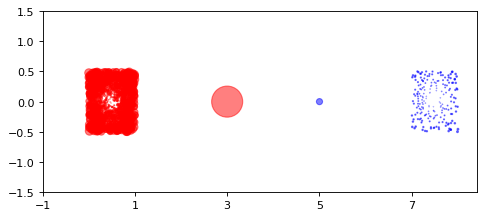

In [5]:
%matplotlib inline
import numpy as np
import random
import csv
import matplotlib.pyplot as plt


#파일로 데이터 입력(Column Name없이), 파일명 : ex_kmc.csv
def loadDataset(filename, split, trainingSet=[] , testSet=[]):
    with open(filename, 'r') as csvfile:
        lines = csv.reader(csvfile)
        dataset = list(lines)
        for x in range(len(dataset)):
            for y in range(2):
                dataset[x][y] = float(dataset[x][y])
            if random.random() < split:
                trainingSet.append(dataset[x])
            else:
                testSet.append(dataset[x])  
  
         
def kmeans(X,k,maxIt):
    numPoints,numDim=X.shape

    dataSet=np.zeros((numPoints,numDim+1))
    dataSet[:,:-1]=X
    centroids=dataSet[np.random.randint(numPoints,size=k),:]
    centroids[:,-1]=range(1,k+1)
    #print("centroids:",centroids)

    iterations=0;
    oldCentroids=None
    while not shouldStop(oldCentroids, centroids, iterations, maxIt):
        oldCentroids=np.copy(centroids)
        iterations+=1
        updateLabels(dataSet, centroids)
        centroids=getCentroids(dataSet, k)
    return dataSet, centroids


def shouldStop(oldCentroids,centroids,iterations,maxIt):
    if iterations>maxIt:
        return True
    return np.array_equal(oldCentroids, centroids)

def updateLabels(dataSet,centroids):
    numPoints,numDim=dataSet.shape
    for i in range(numPoints):
        dataSet[i,-1]=getLabelFromClosestCentroid(dataSet[i,:-1], centroids)

def getLabelFromClosestCentroid(dataSetRow,centroids):
    label=centroids[0,-1]
    minDist=np.linalg.norm(dataSetRow-centroids[0,:-1])
    for i in range(1,centroids.shape[0]):
        dist=np.linalg.norm(dataSetRow-centroids[i,:-1])
        if dist<minDist:
            minDist=dist
            label=centroids[i,-1]
            #print("label:"+str(label))
    return label


def getCentroids(dataSet,k):       
    result=np.zeros((k,dataSet.shape[1]))
    #print("result:",result)
    for i in range(1,k+1):
        oneCluster=dataSet[dataSet[:,-1]==i,:-1]
        #print("cluster:",oneCluster)
        result[i-1,:-1]=np.mean(oneCluster,axis=0)
        result[i-1,-1]=i
    #print("result:",result)
    return result


def getNoveltyScore(dataSetRow,centroids,k):
    minDist=[]  
    maxDist=[]
    for i in range(k):
        Dist=np.linalg.norm(dataSetRow[:,:-1]-centroids[i,:-1],axis=1)   
        minDist.append(Dist)     
    
    NoveltyScore=np.min(minDist,axis=0)
    min_index=np.argmin(minDist,axis=0)
    
    for i in range(k):
        clusterDist=NoveltyScore[np.where(min_index==i)]   
        maxDist.append(np.max(clusterDist))
    
#    a=centroids[min_index,-1]
#    print(a)
    #print(NoveltyScore)
    return NoveltyScore,maxDist


def getModNoveltyScore(kmeans_result,centroid_result,maxDist,k):
    minDist=[]
    countcluster=[]    
    for i in range(k):
        Dist=np.linalg.norm(kmeans_result[:,:-1]-centroid_result[i,:-1],axis=1)
        minDist.append(Dist)
        count=np.sum(kmeans_result[:,-1]==i+1)
        countcluster.append(count)           

    NoveltyScore=np.min(minDist,axis=0)
    weight=(countcluster/np.min(countcluster))/maxDist
    scale_weight=weight/np.min(weight)
    mod_NoveltyScore = NoveltyScore*np.repeat(scale_weight,countcluster,axis=0)

#    print(np.repeat(scale_weight,countcluster,axis=0))
#    print(countcluster)
#    print(np.min(countcluster))
#    print(scale_weight)
#    print(minDist)
#    print(MaxDist)
#    print(NoveltyScore)
   
    return mod_NoveltyScore


def main():
    # prepare data
    trainingSet=[]
    testSet=[]
    split = 1
    random.seed(100)
    loadDataset('C:/Users/myunghoon/.spyder-py3/ex_kmc2.csv', split, trainingSet, testSet)
    trainX=np.array(trainingSet)
    
    #print('Train set: ' ,repr(len(trainingSet)))
    #print('Test set: ' + repr(len(testSet)))
    #print('Train set: ' ,trainingSet[0:10])
    #a=trainX[:,:-1].astype(np.float)
    #plt.scatter(a[:,0], a[:,1]);
    
    # k=군집개수, max_iter=반복 회수 제한(Hyper parameter)   
    k=2
    max_iter=100
    final_result=kmeans(trainX[:,:-1],k,max_iter)

    kmeans_result=final_result[0]
    centroid_result=final_result[1]
    
    NoveltyScore_result=getNoveltyScore(kmeans_result,centroid_result,k)  
    Score=NoveltyScore_result[0]
    maxDist=NoveltyScore_result[1]
    
    print('final centroid:',centroid_result)
    print('maxDist:',maxDist)
    print('Novelty Score:',Score)


    #Outlier제거
    outlier_percentage=0.98
    Distsorting=np.argsort(Score)
    outlier_point=int(Distsorting.shape[0]*outlier_percentage)    
    cutoff_index=Distsorting[0:outlier_point]
    trainX=trainX[cutoff_index]
    
    #두번째 K-Means (새로운 Centroid와 군집의 크기(MaxDist)를 구함)
    final_result_second=kmeans(trainX[:,:-1],k,max_iter)
    kmeans_result_second=final_result_second[0]
    centroid_result_second=final_result_second[1]
    
    NoveltyScore_result_second=getNoveltyScore(kmeans_result_second,centroid_result_second,k)  
#    Score_second=NoveltyScore_result_second[0]
    maxDist_second=NoveltyScore_result_second[1]

    #Relative Distance기반의 Novelty Score    
    RelativeScore=getModNoveltyScore(kmeans_result,centroid_result_second,maxDist_second,k)

    print('final centroid_second:',centroid_result_second)
    print('maxDist_second:',maxDist_second)
    print('Relative Novelty Score:',RelativeScore)    
   
    x=kmeans_result[:,0]
    y=kmeans_result[:,1]
    colors=kmeans_result[:,2]
    
    plt.figure(figsize=(7, 3), dpi=80)
    plt.scatter(x, y, s=(RelativeScore**2)*5, c=colors,alpha=0.5);
    plt.xticks(np.arange(-1,8,2))
    plt.yticks(np.arange(-1.5,1.6,0.5))
    
main()
